Podstawowe informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 84 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             5232 non-null   int64  
 1   location_name           5232 non-null   object 
 2   iso3                    5136 non-null   object 
 3   level                   5232 non-null   object 
 4   year                    5232 non-null   int64  
 5   the_total_mean          5232 non-null   int64  
 6   the_total_lower         5232 non-null   int64  
 7   the_total_upper         5232 non-null   int64  
 8   the_total_ppp_mean      5232 non-null   int64  
 9   the_total_ppp_lower     5232 non-null   int64  
 10  the_total_ppp_upper     5232 non-null   int64  
 11  ghes_total_mean         5232 non-null   int64  
 12  ghes_total_lower        5232 non-null   int64  
 13  ghes_total_upper        5232 non-null   int64  
 14  ghes_tot

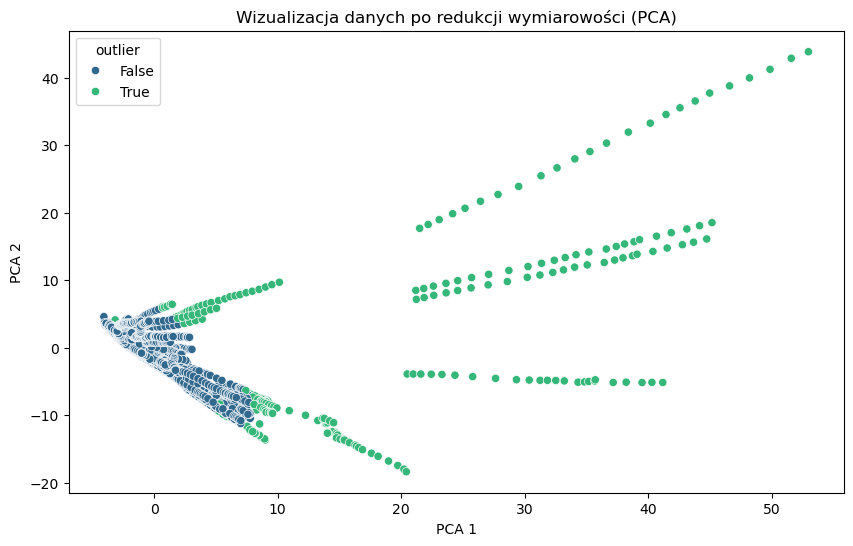

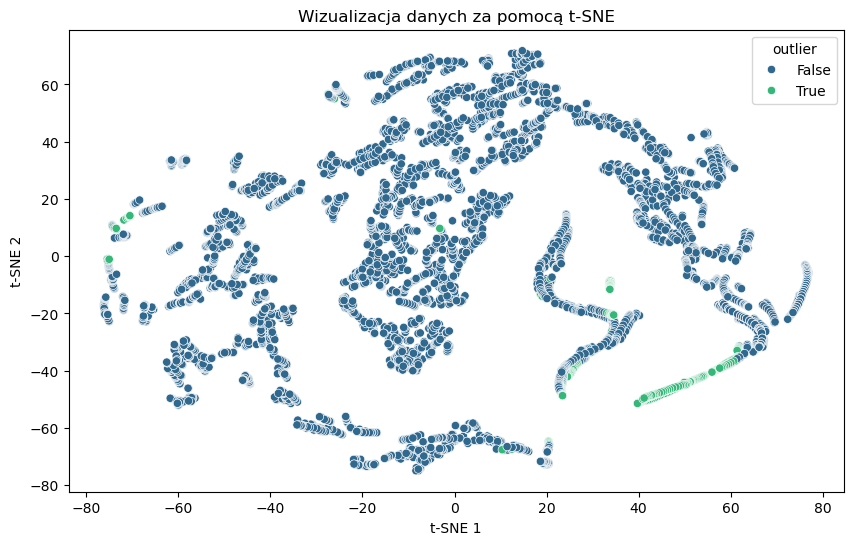

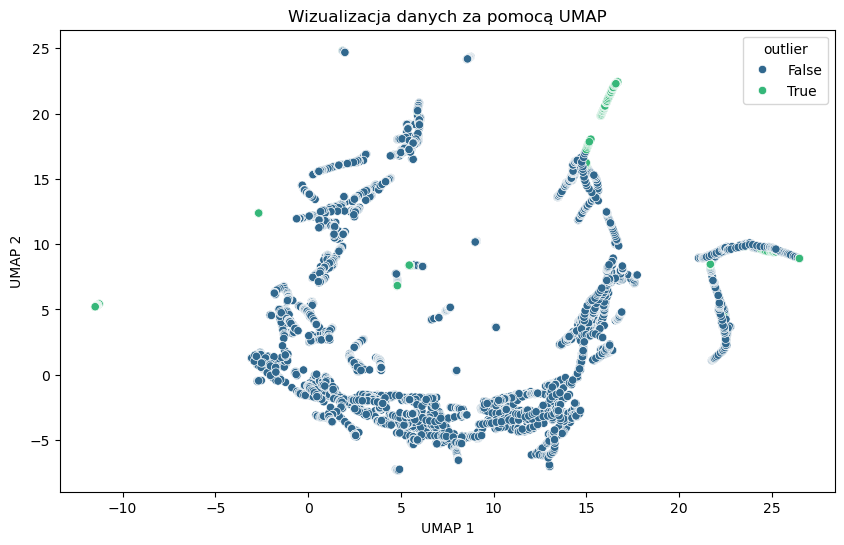

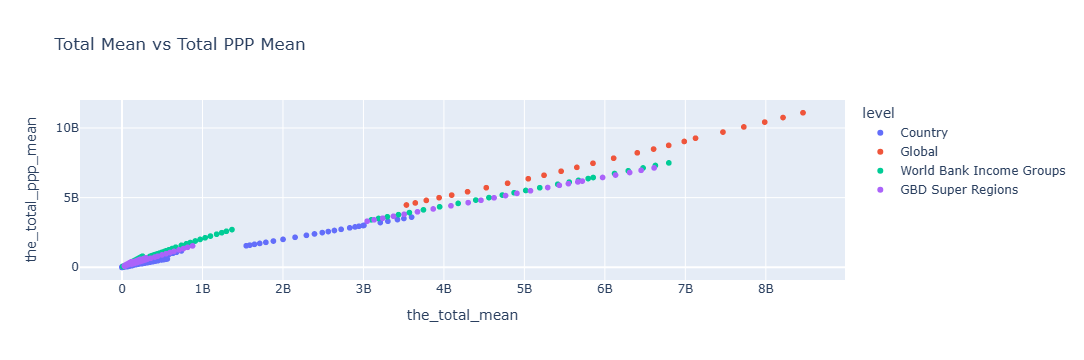

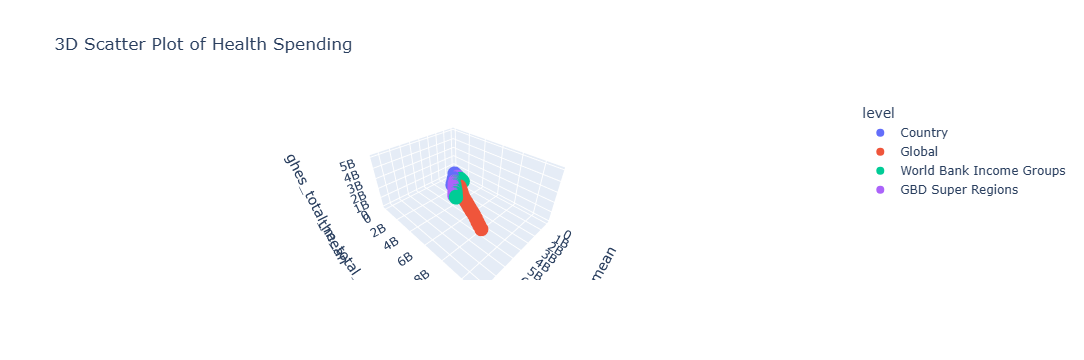

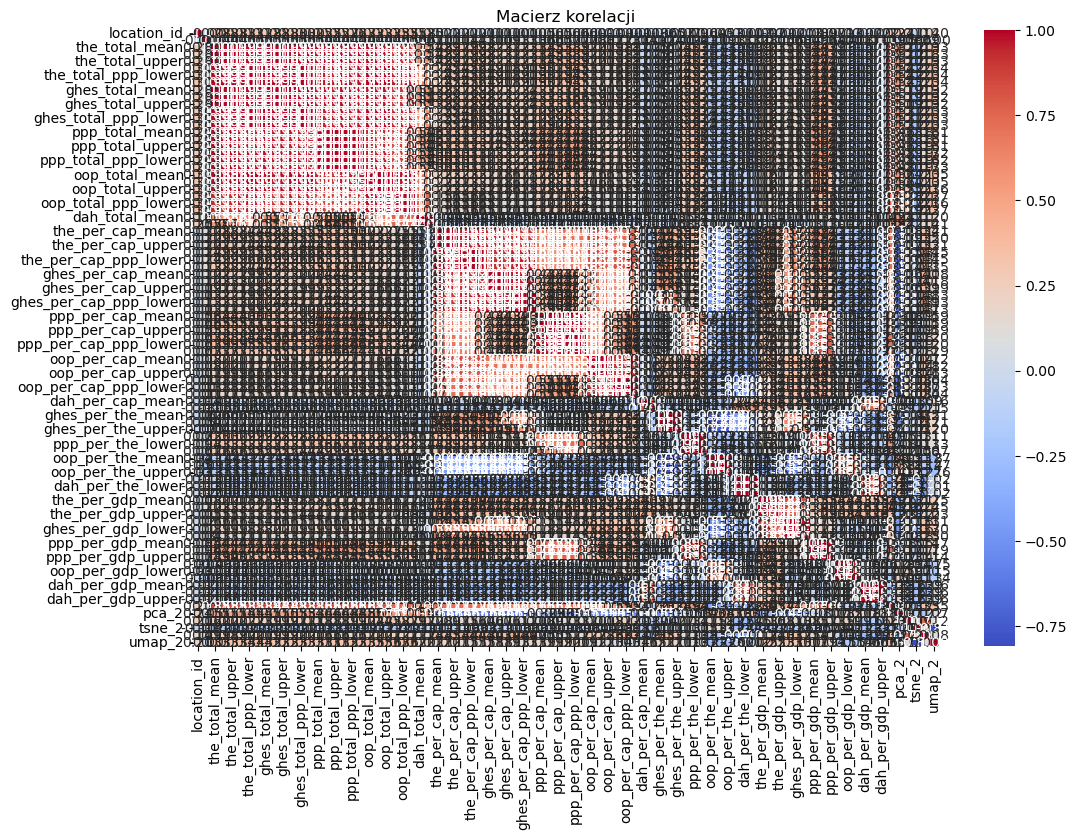

Test t-Studenta między Country a Global: t = -130.12, p = 0.0000
Test t-Studenta między Country a World Bank Income Groups: t = -39.81, p = 0.0000
Test t-Studenta między Country a GBD Super Regions: t = -25.34, p = 0.0000
Test t-Studenta między Global a World Bank Income Groups: t = 9.50, p = 0.0000
Test t-Studenta między Global a GBD Super Regions: t = 15.77, p = 0.0000
Test t-Studenta między World Bank Income Groups a GBD Super Regions: t = 3.72, p = 0.0002


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import ttest_ind

# Wczytanie danych z pliku CSV
df = pd.read_csv('IHME_HEALTH_SPENDING_1995_2018_Y2021M09D22.csv')

# Podstawowe informacje o danych
print("Podstawowe informacje o danych:")
print(df.info())
print("\nPierwsze 5 wierszy danych:")
print(df.head())

# 1. Identyfikacja wartości odstających za pomocą Isolation Forest
def identify_outliers(df):
    # Wybór kolumn numerycznych
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Użycie Isolation Forest do identyfikacji wartości odstających
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(X)
    df['outlier'] = outliers == -1  # -1 oznacza wartość odstającą

    print("\nLiczba wartości odstających:", df['outlier'].sum())
    return df

df = identify_outliers(df)

# 2. Redukcja wymiarowości danych z użyciem PCA
def reduce_dimensionality_pca(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Standaryzacja danych
    X_standardized = (X - X.mean()) / X.std()

    # Redukcja wymiarowości do 2 składników głównych
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_standardized)
    df['pca_1'] = pca_result[:, 0]
    df['pca_2'] = pca_result[:, 1]

    print("\nWyjaśniona wariancja przez PCA:", pca.explained_variance_ratio_)
    return df

df = reduce_dimensionality_pca(df)

# 3. Wizualizacja danych za pomocą PCA
def visualize_pca(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='pca_1', y='pca_2', hue='outlier', data=df, palette='viridis')
    plt.title('Wizualizacja danych po redukcji wymiarowości (PCA)')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

visualize_pca(df)

# 4. Wizualizacja danych wielowymiarowych za pomocą t-SNE i UMAP
def visualize_tsne_umap(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(X)
    df['tsne_1'] = tsne_result[:, 0]
    df['tsne_2'] = tsne_result[:, 1]

    # UMAP
    umap_result = umap.UMAP(n_jobs=-1).fit_transform(X)
    df['umap_1'] = umap_result[:, 0]
    df['umap_2'] = umap_result[:, 1]

    # Wizualizacja t-SNE
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='outlier', data=df, palette='viridis')
    plt.title('Wizualizacja danych za pomocą t-SNE')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

    # Wizualizacja UMAP
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='umap_1', y='umap_2', hue='outlier', data=df, palette='viridis')
    plt.title('Wizualizacja danych za pomocą UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

visualize_tsne_umap(df)

# 5. Interaktywne wizualizacje danych w 2D i 3D
def interactive_visualizations(df):
    # Wykres punktowy 2D
    fig = px.scatter(df, x='the_total_mean', y='the_total_ppp_mean', color='level', title='Total Mean vs Total PPP Mean')
    fig.show()

    # Wykres 3D
    fig = px.scatter_3d(df, x='the_total_mean', y='the_total_ppp_mean', z='ghes_total_mean', color='level', title='3D Scatter Plot of Health Spending')
    fig.show()

interactive_visualizations(df)

# 6. Analiza zależności między zmiennymi za pomocą macierzy korelacji
def correlation_analysis(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Macierz korelacji')
    plt.show()

correlation_analysis(df)

# 7. Testy statystyczne dla analizy różnic w grupach
def statistical_tests(df):
    # Porównanie średnich wydatków między poziomami (np. Country vs Region)
    levels = df['level'].unique()
    for i in range(len(levels)):
        for j in range(i + 1, len(levels)):
            group1 = df[df['level'] == levels[i]]['the_total_mean']
            group2 = df[df['level'] == levels[j]]['the_total_mean']
            t_stat, p_value = ttest_ind(group1, group2)
            print(f"Test t-Studenta między {levels[i]} a {levels[j]}: t = {t_stat:.2f}, p = {p_value:.4f}")

statistical_tests(df)